In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import utils.gmm_helpers as gmm_helpers
import model_params as params

from importlib import reload

import utils.mc_dropout as mc

import argparse


#parser = argparse.ArgumentParser(description='Define hyperparameters.', prefix_chars='-')

#parser.add_argument('--gpu', type=int, default=0, help='GPU index.')
#parser.add_argument('--dataset', type=str, default='MNIST', help='MNIST, FMNIST, SVHN, CIFAR10, CIFAR100')


#hps = parser.parse_args()


dataset = 'MNIST'

saving_string = dataset + '_base'
device = torch.device('cuda:1')

model_params = params.params_dict[dataset](augm_flag=True)

def train(model, device, train_loader, optimizer, epoch, 
          verbose=100, noise_loader=None, epsilon=.3):
    
    criterion = nn.NLLLoss()
    model.train()
    
    train_loss = 0
    correct = 0
    

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        output = F.log_softmax(model(data), dim=1)
        #output = model(data)
        
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        if (batch_idx % verbose == 0) and verbose>0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return train_loss/len(train_loader.dataset), correct/len(train_loader.dataset)


if dataset=='MNIST':
    model = mc.LeNet()
elif dataset=='FMNIST':
    model = mc.vgg13(in_channels=1, num_classes=10)
elif dataset in ['SVHN', 'CIFAR10']:
    model = mc.vgg13(in_channels=3, num_classes=10)
elif dataset=='CIFAR100':
    model = mc.vgg13(in_channels=3, num_classes=100)


model = model.to(device)


param_groups = [{'params':model.parameters(),'lr':model_params.lr, 'weight_decay':5e-4}]
    
if dataset=='MNIST':
    optimizer = optim.Adam(param_groups)
else: 
    optimizer = optim.SGD(param_groups, momentum=0.9)


for epoch in range(100):
    if epoch+1 in [50,75,90]:
        for group in optimizer.param_groups:
            group['lr'] *= .1
 
    trainloss, correct_train = train(model, device, model_params.train_loader,  
                                     optimizer, epoch, verbose=-1)
    print(str(epoch) + ': \t' + str(correct_train))

model = model.to('cpu')

mc_model = mc.MC_Model(model, iterations=10, classes=model_params.classes)

torch.save(mc_model, 'SavedModels/other/mcdo/' + dataset + '.pth')

KeyboardInterrupt: 

In [3]:
reload(mc)
mc_model = mc.MC_Model(model, iterations=7, classes=model_params.classes)
mc_model.cpu()

MC_Model(
  (model): LeNet(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (fc1): Linear(in_features=3136, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=10, bias=True)
    (dropout): MC_dropout(p=0.5)
  )
)

In [8]:
torch.save(mc_model, 'SavedModels/other/mcdo/' + dataset + '.pth')

tensor(0.4970)

In [5]:
x = torch.rand(10, 1, 28, 28)

In [10]:
(1000.*mc_model(x)).exp()

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9563,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9895,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5617,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9698,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9924,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7467,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9423,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9794,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9213,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9823,
         0.0000]], grad_fn=<

In [50]:
data = next(iter(model_params.test_loader))[0]
out_data = next(iter(model_params.loaders[0][1]))[0]

In [94]:
mc_model(data)

tensor([[       -inf,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf, -3.5947e-09,        -inf,        -inf],
        [       -inf,        -inf, -3.7253e-05,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf],
        [       -inf, -4.7048e-06,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf],
        [-2.2564e-04,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf],
        [       -inf,        -inf,        -inf,        -inf, -4.4497e-07,
                -inf,        -inf,        -inf,        -inf,        -inf],
        [       -inf, -5.5477e-07,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf],
        [       -inf,        -inf,        -inf,        -inf, -2.7228e-05,
                -inf,        -in

In [56]:
mc_model(x).max(1)[0].mean()

tensor(-4.4988, grad_fn=<MeanBackward0>)

In [54]:
mc_model(out_data).max(1)[0].mean()

tensor(-6.4220, grad_fn=<MeanBackward0>)

In [65]:
mc_model.model(x)

tensor([[ -5.3726,  -7.9268,  -4.8141,  -7.6775,  -6.1880,  -7.2239,  -4.5580,
          -9.6222,  -0.0298,  -6.0110],
        [ -4.0340,  -6.3577,  -2.2455,  -5.0191,  -4.6770,  -6.3202,  -2.3114,
          -6.5509,  -0.2848,  -5.4524],
        [ -5.2128,  -6.9789,  -3.8566,  -5.2700,  -6.3310,  -7.1379,  -3.7537,
          -8.5233,  -0.0652,  -5.4509],
        [ -6.4082,  -8.8897,  -3.7003,  -6.9389,  -7.3992,  -8.7028,  -4.6785,
         -10.2759,  -0.0408,  -6.0173],
        [ -3.8536,  -6.0161,  -2.8637,  -3.7964,  -5.4262,  -5.1880,  -2.9985,
          -7.1351,  -0.1996,  -4.0651],
        [ -5.1228,  -6.6619,  -4.1636,  -5.2017,  -5.4402,  -6.0420,  -4.3007,
          -7.0575,  -0.0623,  -4.5131],
        [ -4.2476,  -5.9894,  -3.0897,  -5.1981,  -4.7528,  -5.6720,  -3.7552,
          -6.8968,  -0.1245,  -4.3644],
        [ -3.8885,  -5.1258,  -2.5800,  -4.3765,  -4.1712,  -4.9954,  -2.9889,
          -5.7543,  -0.2370,  -3.8859],
        [ -4.5326,  -6.3336,  -3.2776,  -5.1054,

In [87]:
out = []
for _ in range(7):
    out.append(mc_model.model(data).exp())
out = torch.stack(out)
y = out.mean(0)

1000*((out - y[None,:,:])**2).mean(0).sum(1).mean()

tensor(1.9408, grad_fn=<MulBackward0>)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import utils.gmm_helpers as gmm_helpers
import model_params as params

from importlib import reload

import utils.mc_dropout as mc

import argparse

In [ ]:
model = torch.load()

In [40]:
df_multindex = pd.DataFrame(stats_dict,
                             index=[len(metrics)*['MNIST'],
                                    metrics])

In [41]:
print(df_multindex.to_latex())

\begin{tabular}{llrr}
\toprule
      &     &       CCU &      base \\
\midrule
MNIST & TE &  0.999426 &  0.428961 \\
      & MMC &  0.789796 &  0.878765 \\
      & SR &  0.310605 &  0.268120 \\
      & AUC &  0.114866 &  0.535991 \\
\bottomrule
\end{tabular}



In [10]:
mod = torch.load(file)

In [42]:
models = ['base', 'CCU']

In [15]:
model_stats = []

['base', 'CCU']

In [16]:
stats = torch.rand(2, 4, 1)

In [47]:
stats_dict = collections.OrderedDict(zip(models, stats[:,:,0].tolist()))
stats_dict

OrderedDict([('base',
              [0.4289613962173462,
               0.8787645101547241,
               0.26811957359313965,
               0.535990834236145]),
             ('CCU',
              [0.9994264245033264,
               0.7897958755493164,
               0.31060510873794556,
               0.11486554145812988])])

In [45]:
for i, j in zip(models, stats[:,:,0].tolist()):
    print(i)

base
CCU


In [24]:
stats

tensor([[[0.4290],
         [0.8788],
         [0.2681],
         [0.5360]],

        [[0.9994],
         [0.7898],
         [0.3106],
         [0.1149]]])

In [46]:
import collections

In [37]:
file = 'SavedModels/other/mcdo/FMNIST.pth'
model = torch.load(file)

In [33]:
file = 'results/backup/samples_steps500_alpha3.0_restarts50_batches2_batch_size50_FMNIST_2019-09-09 14:19:01.427238_FMNIST.pth'
stats = torch.load(file)

In [17]:
stats.seeds.shape

torch.Size([2, 50, 1, 28, 28])

In [25]:
model(stats.seeds[0]).max(1)[0].mean()

tensor(-5.8868e-05, grad_fn=<MeanBackward0>)

In [29]:
model(stats.samples[0,0]).max(1)[0].exp()

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<ExpBackward>)

In [44]:
file = 'SavedModels/other/mcdo/MNIST.pth'
model = torch.load(file)

In [43]:
reload(mc)

<module 'utils.mc_dropout' from '/home/alexm/project/notebooks/gmm-robust/utils/mc_dropout.py'>

In [45]:
model.model(x)

tensor([[-7.8848e+00, -1.1595e+01, -6.0736e+00, -9.5124e+00, -9.5232e+00,
         -9.6294e+00, -7.7080e+00, -1.2109e+01, -3.5944e-03, -8.3685e+00],
        [-8.5293e+00, -1.0281e+01, -6.0877e+00, -7.1184e+00, -8.3114e+00,
         -7.4821e+00, -7.1142e+00, -1.1321e+01, -5.1584e-03, -8.5258e+00],
        [-8.0917e+00, -1.1280e+01, -7.2941e+00, -8.9765e+00, -7.9143e+00,
         -9.8949e+00, -9.6573e+00, -1.1163e+01, -2.4381e-03, -7.1104e+00],
        [-7.1958e+00, -9.4005e+00, -4.7116e+00, -7.9325e+00, -5.7638e+00,
         -8.7296e+00, -7.2347e+00, -9.8245e+00, -1.4677e-02, -8.0719e+00],
        [-1.1978e+01, -1.3703e+01, -9.5455e+00, -1.0807e+01, -1.1731e+01,
         -1.0837e+01, -9.4580e+00, -1.4891e+01, -2.1172e-04, -1.1890e+01],
        [-1.0263e+01, -1.3445e+01, -8.7900e+00, -9.9919e+00, -1.1504e+01,
         -1.0646e+01, -9.1092e+00, -1.5402e+01, -3.9101e-04, -1.1337e+01],
        [-9.1353e+00, -1.1820e+01, -8.2553e+00, -9.3483e+00, -9.7158e+00,
         -9.2500e+00, -7.9322e+0

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import utils.gmm_helpers as gmm_helpers
import model_params as params

from importlib import reload

import utils.mc_dropout as mc

import argparse


dataset = 'FMNIST'

saving_string = dataset + '_base'
device = torch.device('cuda:4')

model_params = params.params_dict[dataset](augm_flag=True)

def train(model, device, train_loader, optimizer, epoch, 
          verbose=100, noise_loader=None, epsilon=.3):
    
    criterion = nn.NLLLoss()
    model.train()
    
    train_loss = 0
    correct = 0
    

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        #output = F.log_softmax(model(data), dim=1)
        output = model(data)
        
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        if (batch_idx % verbose == 0) and verbose>0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return train_loss/len(train_loader.dataset), correct/len(train_loader.dataset)


if dataset=='MNIST':
    model = mc.LeNet()
elif dataset=='FMNIST':
    model = mc.vgg13(in_channels=1, num_classes=10)
elif dataset in ['SVHN', 'CIFAR10']:
    model = mc.vgg13(in_channels=3, num_classes=10)
elif dataset=='CIFAR100':
    model = mc.vgg13(in_channels=3, num_classes=100)


model = model.to(device)


lr = model_params.lr
lr = 2e-4
param_groups = [{'params':model.parameters(),'lr':lr, 'weight_decay':0.}]
    
if dataset=='MNIST':
    optimizer = optim.Adam(param_groups)
else: 
    optimizer = optim.SGD(param_groups, momentum=0.9)

    
optimizer = optim.Adam(param_groups)

for epoch in range(100):
    if epoch+1 in [50,75,90]:
        for group in optimizer.param_groups:
            group['lr'] *= .1
 
    trainloss, correct_train = train(model, device, model_params.train_loader,  
                                     optimizer, epoch, verbose=-1)
    print(str(epoch) + ': \t' + str(correct_train))

model = model.to('cpu')

0: 	0.5813666666666667
1: 	0.7779833333333334


KeyboardInterrupt: 

In [ ]:
mc_model = mc.MC_Model(model, iterations=10, classes=model_params.classes)

torch.save(mc_model, 'SavedModels/other/mcdo/' + dataset + '.pth')

In [52]:
reload(params)

<module 'model_params' from '/home/alexm/project/notebooks/gmm-robust/model_params.py'>

In [7]:
model(torch.rand(10,1,28,28,device=device)).exp()

tensor([[0.1001, 0.1009, 0.1009, 0.1015, 0.0988, 0.1009, 0.1009, 0.0957, 0.0985,
         0.1019],
        [0.1001, 0.1009, 0.1009, 0.1014, 0.0987, 0.1008, 0.1009, 0.0957, 0.0986,
         0.1019],
        [0.1001, 0.1008, 0.1011, 0.1015, 0.0988, 0.1008, 0.1008, 0.0957, 0.0985,
         0.1020],
        [0.1001, 0.1008, 0.1009, 0.1014, 0.0988, 0.1008, 0.1009, 0.0957, 0.0986,
         0.1020],
        [0.1001, 0.1009, 0.1010, 0.1014, 0.0988, 0.1008, 0.1009, 0.0957, 0.0985,
         0.1020],
        [0.1000, 0.1009, 0.1009, 0.1014, 0.0988, 0.1009, 0.1009, 0.0957, 0.0986,
         0.1019],
        [0.1001, 0.1009, 0.1010, 0.1014, 0.0988, 0.1008, 0.1008, 0.0957, 0.0985,
         0.1019],
        [0.1001, 0.1009, 0.1010, 0.1015, 0.0988, 0.1008, 0.1008, 0.0958, 0.0985,
         0.1019],
        [0.1001, 0.1009, 0.1009, 0.1014, 0.0988, 0.1008, 0.1008, 0.0958, 0.0985,
         0.1019],
        [0.1001, 0.1009, 0.1010, 0.1014, 0.0988, 0.1008, 0.1008, 0.0957, 0.0985,
         0.1019]], device='c

In [65]:
reload(dl)

<module 'utils.dataloaders' from '/home/alexm/project/notebooks/gmm-robust/utils/dataloaders.py'>

In [66]:
loader = dl.TinyImages('MNIST')

In [67]:
data = next(iter(loader))[0]

In [68]:
data.shape

torch.Size([128, 1, 28, 28])

In [ ]:
loader.batch_size

In [27]:
loader

In [1]:
import torch

In [3]:
a = torch.rand(10)

In [4]:
a

tensor([0.6662, 0.2200, 0.8140, 0.3196, 0.8920, 0.0562, 0.4096, 0.1929, 0.5605,
        0.1893])

In [5]:
a.median()

tensor(0.3196)

In [2]:
model = torch.load('SavedModels/other/mcdo/SVHN.pth')

In [4]:
model.model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace)
    (17): Conv2d

In [5]:
import utils.maha_orig

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import utils.gmm_helpers as gmm_helpers
import model_params as params

from importlib import reload

import utils.mc_dropout as mc

import argparse

In [103]:
device = torch.device('cuda:7')
model = torch.load('SavedModels/other/mcdo/MNIST.pth').to(device)

In [5]:
model.model(torch.rand(10,3,32,32)).exp()

tensor([[2.8804e-03, 1.7448e-04, 7.3236e-01, 9.2889e-03, 1.6873e-02, 1.6071e-03,
         2.3579e-01, 6.3311e-05, 9.3219e-04, 3.3302e-05],
        [4.1709e-05, 3.6959e-06, 1.4710e-01, 3.0959e-05, 4.8656e-03, 9.5192e-07,
         8.4768e-01, 2.1659e-07, 2.7373e-04, 2.0173e-07],
        [7.7012e-07, 1.3498e-08, 3.6277e-02, 2.6285e-03, 1.5259e-03, 4.0689e-05,
         9.5952e-01, 3.0530e-07, 2.0190e-06, 3.8262e-08],
        [6.5478e-03, 2.8062e-03, 8.3580e-02, 2.8812e-01, 8.9296e-03, 7.8002e-03,
         5.8434e-01, 8.3119e-04, 3.4306e-03, 1.3612e-02],
        [1.1907e-03, 1.8654e-04, 1.1173e-01, 3.3944e-02, 1.1603e-02, 1.1087e-03,
         8.3966e-01, 8.8793e-05, 1.7819e-04, 3.0764e-04],
        [1.2291e-04, 9.0490e-05, 3.6043e-02, 5.3851e-03, 1.9022e-03, 1.0737e-04,
         9.5611e-01, 2.0288e-06, 1.6293e-04, 7.5208e-05],
        [1.8380e-06, 3.3532e-06, 1.4044e-02, 5.0767e-03, 1.5441e-04, 8.0171e-06,
         9.8069e-01, 1.8511e-07, 1.9558e-05, 5.6284e-06],
        [2.0336e-04, 5.3181

In [104]:
data, label = next(iter(dl.MNIST(train=False)))
data = data.to(device)

In [89]:
vals = []
for i in range(500):
    vals.append(model.model(data).exp()[1,[8, 2, 6]].detach().cpu())
vals = torch.stack(vals, 0)

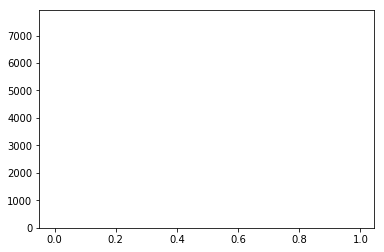

In [84]:
for i in range(3):
    plt.hist(vals[:,i], density=True, alpha=.5)
plt.show()


In [73]:
x = torch.rand(20, 3, 32, 32, device=device)

vals_x = []
for i in range(500):
    vals_x.append(model.model(x).exp()[0,[8, 2, 6]].detach().cpu())
vals_x = torch.stack(vals_x, 0)

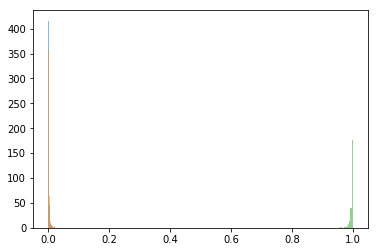

In [80]:
for i in range(3):
    plt.hist(vals_x[:,i], density=True, alpha=.5)
plt.show()


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 499.]),
 array([0.99999422, 0.9999948 , 0.99999537, 0.99999595, 0.99999653,
        0.99999711, 0.99999769, 0.99999827, 0.99999884, 0.99999942,
        1.        ]),
 <a list of 10 Patch objects>)

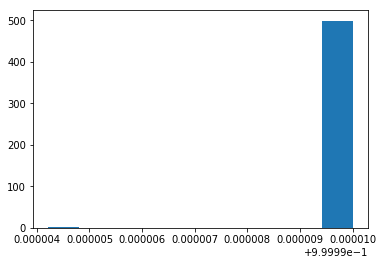

In [90]:
plt.hist(vals[:,0])

In [98]:
(model.model(data).exp().max(1)[0] > .9999).float().mean()

tensor(0.5800, device='cuda:7')

In [99]:
model.model(data).exp().max(1)[0]

tensor([0.9918, 1.0000, 0.5235, 0.9728, 1.0000, 1.0000, 0.9998, 0.9993, 0.9991,
        0.9450, 0.9995, 1.0000, 0.9987, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9707, 0.9832, 0.9996, 1.0000, 0.9994, 1.0000, 0.6396,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6656, 1.0000, 0.4900,
        0.9662, 0.8447, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999,
        1.0000, 0.9998, 0.9969, 1.0000, 0.9969, 1.0000, 1.0000, 0.6264, 0.9999,
        1.0000, 1.0000, 0.9999, 0.6083, 0.9196, 1.0000, 1.0000, 0.9286, 1.0000,
        0.9436, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9115, 0.6169, 0.9995,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9656, 0.9986, 0.5918, 1.0000, 1.0000,
        0.9960, 1.0000, 0.9994, 0.9993, 0.7856, 0.9943, 0.9479, 1.0000, 1.0000,
        1.0000, 0.9994, 1.0000, 1.0000, 0.9936, 1.0000, 0.9997, 0.9963, 1.0000,
        1.0000], device='cuda:7', grad_fn=<MaxBackward0>)

In [102]:
model.model(x).exp().max(1)[0]

tensor([0.6131, 0.6878, 0.9988, 0.9865, 0.7849, 0.9531, 0.6701, 0.4484, 0.8191,
        0.7190, 0.9955, 0.8988, 0.8874, 0.9814, 0.6740, 0.9412, 0.5401, 0.7917,
        0.9257, 0.9743], device='cuda:7', grad_fn=<MaxBackward0>)

In [106]:
x = torch.rand(20, 1, 28, 28, device=device)

In [108]:
model.model(x).exp().max(1)

torch.return_types.max(
values=tensor([0.9989, 0.9932, 0.9834, 0.9992, 0.9904, 0.9887, 0.9941, 0.9976, 0.9964,
        0.9925, 0.9990, 0.9989, 0.9995, 0.9955, 0.9947, 0.9997, 0.9878, 0.9964,
        0.9963, 0.9902], device='cuda:7', grad_fn=<MaxBackward0>),
indices=tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       device='cuda:7'))

In [109]:
model.model(data).exp().max(1)

torch.return_types.max(
values=tensor([1.0000, 0.9999, 0.9992, 1.0000, 1.0000, 1.0000, 0.9995, 0.9995, 0.9716,
        0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 1.0000,
        0.9745, 1.0000, 0.9999, 0.9997, 0.9999, 1.0000, 0.9999, 0.9984, 0.9999,
        1.0000, 0.9999, 0.9998, 1.0000, 0.9998, 1.0000, 0.9999, 1.0000, 1.0000,
        0.9998, 1.0000, 0.9995, 0.9999, 0.9985, 0.9946, 0.9998, 0.9958, 0.9976,
        0.9989, 0.9999, 1.0000, 0.9950, 1.0000, 0.9998, 1.0000, 0.9999, 0.9999,
        0.9999, 1.0000, 1.0000, 0.9978, 0.9999, 0.9993, 1.0000, 1.0000, 0.8628,
        0.9976, 1.0000, 0.9940, 0.9994, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9864, 0.9999, 0.9998, 1.0000, 0.9999, 0.9924, 0.9996, 0.9994,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9960, 0.9999, 0.9995,
        1.0000, 1.0000, 0.9197, 1.0000, 0.9992, 0.9950, 0.9978, 0.9995, 0.9997,
        1.0000], device='cuda:7', grad_fn=<MaxBackward0>),
indices=tensor([7, 2, 1, 0, 4,